In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/Shared drives/deep learning"



Mounted at /gdrive
/gdrive/Shared drives/deep learning


In [5]:


# Path to the data directory
data_dir_train = "data/images_mix"
label_path_train = "data/labels_text_mix.json"
data_dir_test = "data/images_larger"
label_path_test = "data/labels.json"
epochs = 50

checkpoint_path = "checkpoints/ctc_large_images"
model_name = "{}_epochs".format(epochs)
model_save_path = os.path.join(checkpoint_path, model_name)
model_load_path = os.path.join(checkpoint_path, model_name)
#model.save_weights(model_save_path)
#model.load_weights(model_load_path)

MAX_TEXT_SIZE=50
labels_train = []
labels_test = []
# Get list of all the images
#training dataset
images_train = glob.glob(os.path.join(data_dir_train, "*.ogg.png"))[:5000]
# images_train = glob.glob(os.path.join(data_dir_train, "*.ogg.png"))
text_labels_train = [img.split(os.path.sep)[-1].split(".ogg.png")[0] for img in images_train][:5000]

with open(label_path_train) as f:
  data_dict = json.load(f)
  for l in text_labels_train:
    labels_train.append(data_dict[l].ljust(MAX_TEXT_SIZE).lower())


images_test = [f for f in glob.glob(os.path.join(data_dir_test, "*.ogg.png")) if "bell" in f][:100]
text_labels_test = [img.split(os.path.sep)[-1].split(".ogg.png")[0] for img in images_test][:100]

#testing dataset
with open(label_path_test) as f:
  data_dict = json.load(f)
  for l in text_labels_test:
    if '(1)' in l:
      continue
    labels_test.append(data_dict[l].ljust(MAX_TEXT_SIZE).lower())



characters = list('abcdefghijklmnopqrstuvwxyz0123456789,.?;:-_()=+@$!&/\'\" ')

print("Number of images found: ", len(images_train))
print("Number of labels found: ", len(labels_train))
print("Number of images found: ", len(images_test))
print("Number of labels found: ", len(labels_test))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

batch_size = 32

# Desired image dimensions
img_width = 600
img_height =500
# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels_train])

Number of images found:  5000
Number of labels found:  5000
Number of images found:  100
Number of labels found:  100
Number of unique characters:  55
Characters present:  ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ',', '.', '?', ';', ':', '-', '_', '(', ')', '=', '+', '@', '$', '!', '&', '/', "'", '"', ' ']


In [6]:
print(images_test)

['data/images_larger/110_bell.ogg.png', 'data/images_larger/319_bell.ogg.png', 'data/images_larger/1601_bell.ogg.png', 'data/images_larger/1346_bell.ogg.png', 'data/images_larger/700_bell.ogg.png', 'data/images_larger/698_bell.ogg.png', 'data/images_larger/1873_bell.ogg.png', 'data/images_larger/934_bell.ogg.png', 'data/images_larger/1618_bell.ogg.png', 'data/images_larger/1997_bell.ogg.png', 'data/images_larger/82_bell.ogg.png', 'data/images_larger/977_bell.ogg.png', 'data/images_larger/1553_bell.ogg.png', 'data/images_larger/203_bell.ogg.png', 'data/images_larger/1563_bell.ogg.png', 'data/images_larger/518_bell.ogg.png', 'data/images_larger/590_bell.ogg.png', 'data/images_larger/914_bell.ogg.png', 'data/images_larger/1811_bell.ogg.png', 'data/images_larger/1123_bell.ogg.png', 'data/images_larger/1756_bell.ogg.png', 'data/images_larger/354_bell.ogg.png', 'data/images_larger/78_bell.ogg.png', 'data/images_larger/912_bell.ogg.png', 'data/images_larger/1159_bell.ogg.png', 'data/images_la

In [7]:
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


# def split_data(images, labels, test_size=0.9, shuffle=True):
#     # 1. Get the total size of the dataset
#     size = len(images)

#     # 2. Make an indices array and shuffle it, if required
#     indices = np.arange(size)
#     if shuffle:
#         np.random.shuffle(indices)

#     # 3. Get the size of training samples
#     test_samples = int(size * test_size)

#     # 4. Split data into training and test sets
#     x_train, y_train = images[indices[:test_samples]], labels[indices[:test_samples]]
#     x_test, y_test = images[indices[test_samples:]], labels[indices[test_samples:]]
#     return x_test, y_test

# # Splitting data into training and test sets


x_train = images_train
x_test = images_test
y_train =labels_train
y_test = labels_test

def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

shuffle_buffer_size = len(train_dataset)
train_dataset = train_dataset.shuffle(shuffle_buffer_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = (
    test_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [ ]:
# for batch in train_dataset.take(1):
#   images = batch["image"]
#   labels = batch["label"]
#   print(labels)
#   break
# print(text_labels[1])

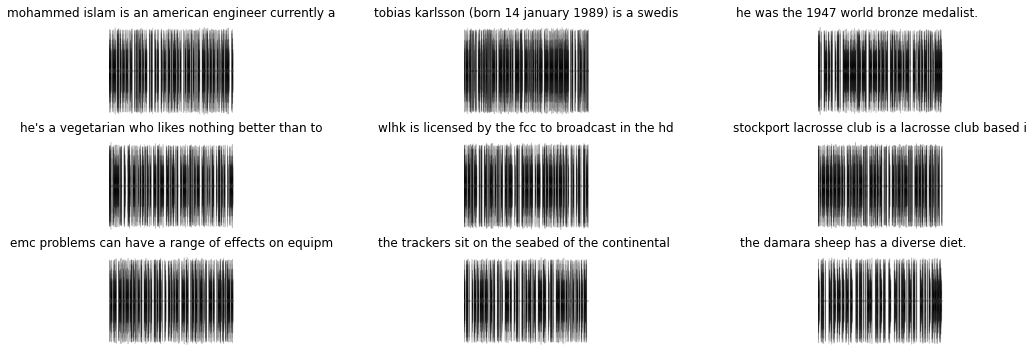

In [ ]:
n = 3
_, ax = plt.subplots(n, n, figsize=(n*6, n*2))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(n**2):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // n, i % n].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // n, i % n].set_title(label)
        ax[i // n, i % n].axis("off")
plt.show()

In [9]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
        
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)
    x= layers.Dropout(0.3)(x)
    # Second conv block
    x = layers.Conv2D(
        16,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv3",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool3")(x)
    x= layers.Dropout(0.4)(x)
    
    # x = layers.Conv2D(
    #     8,
    #     (3, 3),
    #     activation="relu",
    #     kernel_initializer="he_normal",
    #     padding="same",
    #     name="Conv2",
    # )(x)
    # x = layers.MaxPooling2D((2, 2), name="pool2")(x)
    # x= layers.Dropout(0.4)(x)
    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height //4) * 16)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(8, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.3)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(16, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(characters) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt,metrics = [tf.keras.metrics.Accuracy()])
    return model


In [10]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 600, 500, 1) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 600, 500, 32) 320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 300, 250, 32) 0           Conv1[0][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (None, 300, 250, 32) 0           pool1[0][0]                      
_______________________________________________________________________________________

In [11]:
epochs = epochs
early_stopping_patience = 5
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    callbacks=[early_stopping])

Epoch 1/50
157/157 [==============================] - 34s 219ms/step - loss: 199.4484 - accuracy: 0.0000e+00 - val_loss: 152.1092 - val_accuracy: 0.0000e+00
Epoch 2/50
157/157 [==============================] - 19s 121ms/step - loss: 152.4940 - accuracy: 0.0000e+00 - val_loss: 150.9837 - val_accuracy: 0.0000e+00
Epoch 3/50
157/157 [==============================] - 19s 120ms/step - loss: 151.9388 - accuracy: 0.0000e+00 - val_loss: 150.6125 - val_accuracy: 0.0000e+00
Epoch 4/50
157/157 [==============================] - 19s 122ms/step - loss: 151.6138 - accuracy: 0.0000e+00 - val_loss: 149.9557 - val_accuracy: 0.0000e+00
Epoch 5/50
157/157 [==============================] - 19s 120ms/step - loss: 151.3807 - accuracy: 0.0000e+00 - val_loss: 149.7020 - val_accuracy: 0.0000e+00
Epoch 6/50
157/157 [==============================] - 19s 122ms/step - loss: 151.1462 - accuracy: 0.0000e+00 - val_loss: 149.8755 - val_accuracy: 0.0000e+00
Epoch 7/50
157/157 [==============================] - 19s 

In [12]:
# epochs = epochs
# early_stopping_patience = 5
# # Add early stopping
# early_stopping = keras.callbacks.EarlyStopping(
#     monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
# )

# # Train the model
# history = model.fit(
#     train_dataset,
#     validation_split=0.2,
#     epochs=epochs,
#     callbacks=[early_stopping])

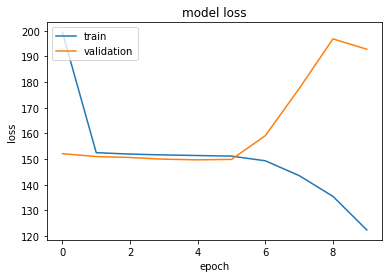

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [15]:
model.evaluate(test_dataset) 

4/4 [==============================] - 0s 38ms/step - loss: 149.7020 - accuracy: 0.0000e+00


[149.70199584960938, 0.0]

In [18]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
#prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


def count_num_errors(pred_texts, orig_texts):
  err_w = 0
  err_c = 0
  total_words = 0
  total_chars = 0
  for i in range(len(pred_texts)):
    pred_text = pred_texts[i]
    orig_text = orig_texts[i]

    pred_tokens = pred_text.split()
    orig_tokens = orig_text.split()

    pred_w_len = len(pred_tokens)
    orig_w_len = len(orig_tokens)
    total_words += max(pred_w_len, orig_w_len)
    # err_w = 0
    for w in range(min(pred_w_len, orig_w_len)):
      if pred_tokens[w] != orig_tokens[w]:
        err_w += 1
    
    pred_c_len = len(pred_text)
    orig_c_len = len(orig_text)
    total_chars += max(pred_c_len, orig_c_len)

    for c in range(min(pred_c_len, orig_c_len)):
      if pred_text[c] != orig_text[c]:
        err_c += 1
  return err_w, total_words, err_c, total_chars


# For random sampling from each batch
import random
samples_per_batch = 1
sample_text = ""
err_w, total_words, err_c, total_chars = 0, 0, 0, 0

# Iterate over the test dataset batches
sample_ind = 1
for batch in test_dataset.as_numpy_iterator():
  batch_images = batch["image"]
  batch_labels = batch["label"]
  
  preds = prediction_model.predict(batch_images)
  pred_texts = decode_batch_predictions(preds)

  orig_texts = []
  for label in batch_labels:
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    orig_texts.append(label)

  m1, m2, m3, m4 = count_num_errors(pred_texts, orig_texts)
  err_w += m1
  total_words += m2
  err_c += m3
  total_chars += m4

  if random.random() < 0.4:
    batch_size = len(pred_texts)
    sample_indices = random.sample(range(batch_size), samples_per_batch)
    for i in sample_indices:
      sample_text += "Sample #{}\n".format(sample_ind)
      sample_text += "Ground truth:  \t{}\n".format(orig_texts[i])
      sample_text += "Reconstruction:\t{}\n\n".format(pred_texts[i])
      sample_ind += 1

word_error = err_w / total_words if total_words != 0 else 0
char_error = err_c / total_chars if total_chars != 0 else 0
accuracy_text = "Accurate words: \t{}/{}\n".format(total_words - err_w, total_words)
accuracy_text += "Word level accuracy: \t{}\n\n".format(1 - word_error)
accuracy_text += "Accurate chars: \t{}/{}\n".format(total_chars - err_c, total_chars)
accuracy_text += "Char level accuracy: \t{}\n".format(1 - char_error)

print(accuracy_text)
print(sample_text)

Accurate words: 	773/873
Word level accuracy: 	0.8854524627720504

Accurate chars: 	20000/25000
Char level accuracy: 	0.8

Sample #1
Ground truth:  	he has also drove in the britcar 24 hour race.    
Reconstruction:	[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]

Sample #2
Ground truth:  	she has served in the house of assembly since 2010
Reconstruction:	[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]




In [17]:
model.save_weights(model_save_path)